## **Step 1: Introduction**

In this project, we are going to build a GAN that generates images in Monet-style. A generative adversarial network contains two parts: one is a generator model which learns to generate plausible data, and the other is discriminator model which learns to distinguish the generator's fake data from real data.

The data we use is from a Kaggle competition (https://www.kaggle.com/competitions/gan-getting-started/overview), and it contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet directories are the same painting images, and they contain Monet paintings. The photo directories are also the same photos, our goal is add Monet-style to these images.

## **Step 2: Exploratory Data Analysis**

### 2.1. Load Libraries and Data

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tqdm
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

AUTOTUNE = tf.data.experimental.AUTOTUNE

import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
monet_dir = "../input/gan-getting-started/monet_jpg/"
photo_dir = "../input/gan-getting-started/photo_jpg/"
monet_jpg = os.listdir(monet_dir)
photo_jpg = os.listdir(photo_dir)

In [5]:
print("number of images in Monet file: ", len(monet_jpg))
print("number of images in photo file: ", len(photo_jpg))

number of images in Monet file:  300
number of images in photo file:  7038


### 2.2 Visualizations

Here are some samples of real Monet's paintings from the dataset, and some samples of photos that we are going to generate into Monet's style. 

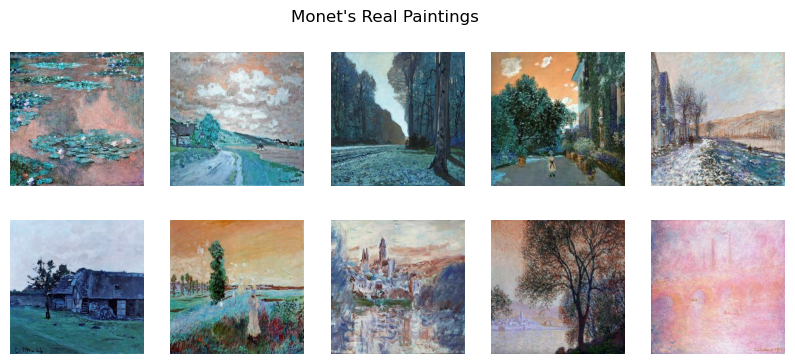

In [7]:
plt.figure(figsize = (10, 4))
for ind, image_name in enumerate(monet_jpg[0:10]):
    img = cv2.imread(os.path.join(monet_dir, image_name))
    plt.subplot(2, 5, ind+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Monet's Real Paintings")
plt.show()

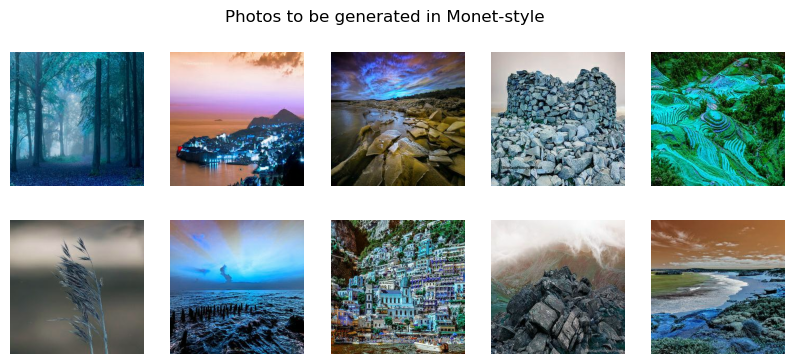

In [8]:
plt.figure(figsize = (10, 4))
for ind, image_name in enumerate(photo_jpg[0:10]):
    img = cv2.imread(os.path.join(photo_dir, image_name))
    plt.subplot(2, 5, ind+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Photos to be generated in Monet-style")
plt.show()

In [9]:
monet = []
for file in tqdm.tqdm(monet_jpg):
    image_path = os.path.join(monet_dir, file)
    image = cv2.imread(image_path)
    monet.append(image)

monet = np.array(monet)

100%|██████████| 300/300 [00:01<00:00, 248.90it/s]


In [10]:
photo = []
for file in tqdm.tqdm(photo_jpg):
    image_path = os.path.join(photo_dir, file)
    image = cv2.imread(image_path)
    photo.append(image)

photo = np.array(photo)

100%|██████████| 7038/7038 [00:28<00:00, 250.87it/s]


In [11]:
print(monet.shape)
print(photo.shape)

(300, 256, 256, 3)
(7038, 256, 256, 3)


### 2.3 Data Augmentation

Here we are going to first convert array to tensorflow for processing, then we are going to rescaling the images to [-1, 1], and then we are going to have some data augmentation to avoid overfitting.


In [12]:
monet = tf.data.Dataset.from_tensor_slices(monet)
photo = tf.data.Dataset.from_tensor_slices(photo)

In [13]:
# normalizate the image to be in the [-1, 1]
def normalize(image):
    img = (tf.cast(image, tf.float32) / 127.5) - 1
    return img
# random crop
# def random_crop(image):
#     cropped = tf.image.random_crop(image, size = [256, 256, 3])
#     return cropped

def random_flip(image):
#     img = tf.image.resize(image, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     img = random_crop(img)
    img = tf.image.random_flip_left_right(image)
    return img

def preprocess_image(image):
    img = random_flip(image)
    img = normalize(img)
    return img

In [14]:
monet1 = monet.cache().map(
    preprocess_image, num_parallel_calls=AUTOTUNE).shuffle(
    1000).batch(1)

photo1 = photo.cache().map(
    preprocess_image, num_parallel_calls=AUTOTUNE).shuffle(
    1000).batch(1)

In [15]:
sample_monet = next(iter(monet1))
sample_photo = next(iter(photo1))

## **Step 3: Build the generator**

Before we build the generator, we will first define the downsample and upsample methods.

According to the tutorial, the downsample will reduce the 2D dimensions of the image by the stride. And the upsample just do the opposite of the downsample method, which will increas the dimensions of the image.

***Resources: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/***

In [16]:
def Generator():
    init = RandomNormal(stddev = 0.02)
    inputs = Input(shape = [256, 256, 3])
    
    # downsample 64
    g = Conv2D(64, (7,7), padding = 'same', kernel_initializer = init)(inputs)
    g = tfa.layers.InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # downsample 128
    g = Conv2D(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer = init)(g)
    g = tfa.layers.InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    # downsample 256
    g = Conv2D(256, (3,3), strides = (2,2), padding = 'same', kernel_initializer = init)(g)
    g = tfa.layers.InstanceNormalization(axis = -1)(g)
    g = Activation('relu')(g)
    
    # resnet
    for _ in range(8):
        init = RandomNormal(stddev = 0.02)
        # first convolutional layer
        k = Conv2D(256, (3,3), padding = 'same', kernel_initializer = init)(g)
        k = tfa.layers.InstanceNormalization(axis = -1)(k)
        k = Activation('relu')(k)
        # second convolutional layer
        k = Conv2D(256, (3,3), padding = 'same', kernel_initializer = init)(k)
        k = tfa.layers.InstanceNormalization(axis = -1)(k)
        # concatenate merge channel-wise with input layer
        k = Concatenate()([k, g])
        
    # upsample 128
    k = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer = init)(k)
    k = tfa.layers.InstanceNormalization(axis = -1)(k)
    k = Activation('relu')(k)
    # upsample 64
    k = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer = init)(k)
    k = tfa.layers.InstanceNormalization(axis = -1)(k)
    k = Activation('relu')(k)
    
    k = Conv2D(3, (7,7), padding = 'same', kernel_initializer = init)(k)
    k = tfa.layers.InstanceNormalization(axis = -1)(k)
    out_image = Activation('tanh')(k)
        
    model = Model(inputs, out_image)
    return model

In [17]:
generator_g = Generator()

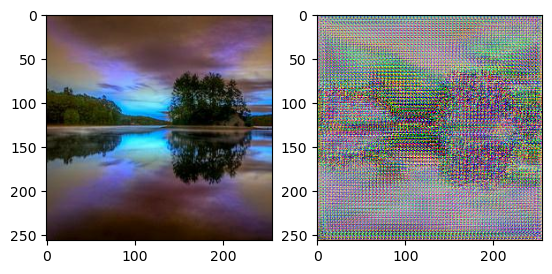

In [18]:
to_monet = generator_g(sample_photo[0][tf.newaxis,...], training=False)

plt.subplot(1,2,1)
plt.imshow(sample_photo[0] * 0.5 + 0.5) 

plt.subplot(1,2,2)
plt.imshow(to_monet[0] * 0.5 + 0.5) 

plt.show()

## **Step 4: Build the discriminator**

In this step, we are going to build discriminator, which takes in the input image and classifies it is real or it is fake. 

In [19]:
def Discriminator():
    init = RandomNormal(stddev = 0.02)
    
    inp = Input(shape = [256, 256, 3], name = 'input_image')
#     tar = Input(shape=[256, 256, 3], name='target_image')
#     in_image = tf.keras.layers.concatenate([inp, tar])
    
    # downsample 64
    d = Conv2D(64, (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(inp)
    d = LeakyReLU(alpha=0.2)(d)
    # down sample 128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # downsample 256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # ZERO PADDING 1
    d = layers.ZeroPadding2D()(d)
    d = Conv2D(512, (4,4), strides=(1,1), padding='valid', kernel_initializer=init)(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # ZERO PADDING 2
    d = layers.ZeroPadding2D()(d)
    # patch output
    outputs = Conv2D(1, (4,4), strides=(1,1), padding='valid', kernel_initializer=init)(d)
        
    return Model(inputs=inp, outputs=outputs)

In [20]:
with strategy.scope():
    monet_generator = Generator() # transform photos to Monet-style
    photo_generator = Generator() # transform Monet paintings to be more like photos

    monet_discriminator = Discriminator() 
    photo_discriminator = Discriminator()

## **Step 5: Build CycleGAN Model and Train the Model**

Now we are going to create a CycleGAN model. First, it will have a train_step, and that is to transform a photo to a Monet-style painting, and then back to a photo, also, it will evaluate the generator/discriminator loss in this class.

Also, we will define serveral loss functions which will return discriminator loss(the average of the real and fake loss), the generator loss, cycle consistency loss(check if original photo and the photo had twice transformed are similar to one another), and the identity loss(the image with its generator)

**References: https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings**

In [21]:
class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

In [22]:
with strategy.scope():
    # use BinaryCrossentropy reduction to compute mean_loss
    bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    
    def discriminator_loss(real, generated):
        real_loss = bce_loss(tf.ones_like(real), real)
        generated_loss = bce_loss(tf.zeros_like(generated), generated)
        disc_loss = (real_loss + generated_loss) / 2
        return disc_loss
    
    def generator_loss(generated):
        return bce_loss(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss
    
    def identity_loss(real_image, same_image, LAMBDA=1.0):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [23]:
lr = 0.0001
beta = 0.5
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [27]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet1, photo1)),
    epochs=15
)

Epoch 1/15
300/300 [==============================] - 137s 326ms/step - monet_gen_loss: 8.6692 - photo_gen_loss: 8.6919 - monet_disc_loss: 0.5686 - photo_disc_loss: 0.6064
Epoch 2/15
300/300 [==============================] - 99s 326ms/step - monet_gen_loss: 7.7548 - photo_gen_loss: 7.8399 - monet_disc_loss: 0.5257 - photo_disc_loss: 0.5149
Epoch 3/15
300/300 [==============================] - 98s 325ms/step - monet_gen_loss: 7.7275 - photo_gen_loss: 7.8152 - monet_disc_loss: 0.4850 - photo_disc_loss: 0.4934
Epoch 4/15
300/300 [==============================] - 99s 326ms/step - monet_gen_loss: 7.6596 - photo_gen_loss: 7.5880 - monet_disc_loss: 0.4419 - photo_disc_loss: 0.4761
Epoch 5/15
300/300 [==============================] - 99s 325ms/step - monet_gen_loss: 7.5693 - photo_gen_loss: 7.5445 - monet_disc_loss: 0.4335 - photo_disc_loss: 0.4388
Epoch 6/15
300/300 [==============================] - 99s 326ms/step - monet_gen_loss: 7.6526 - photo_gen_loss: 7.5196 - monet_disc_loss: 0.4321

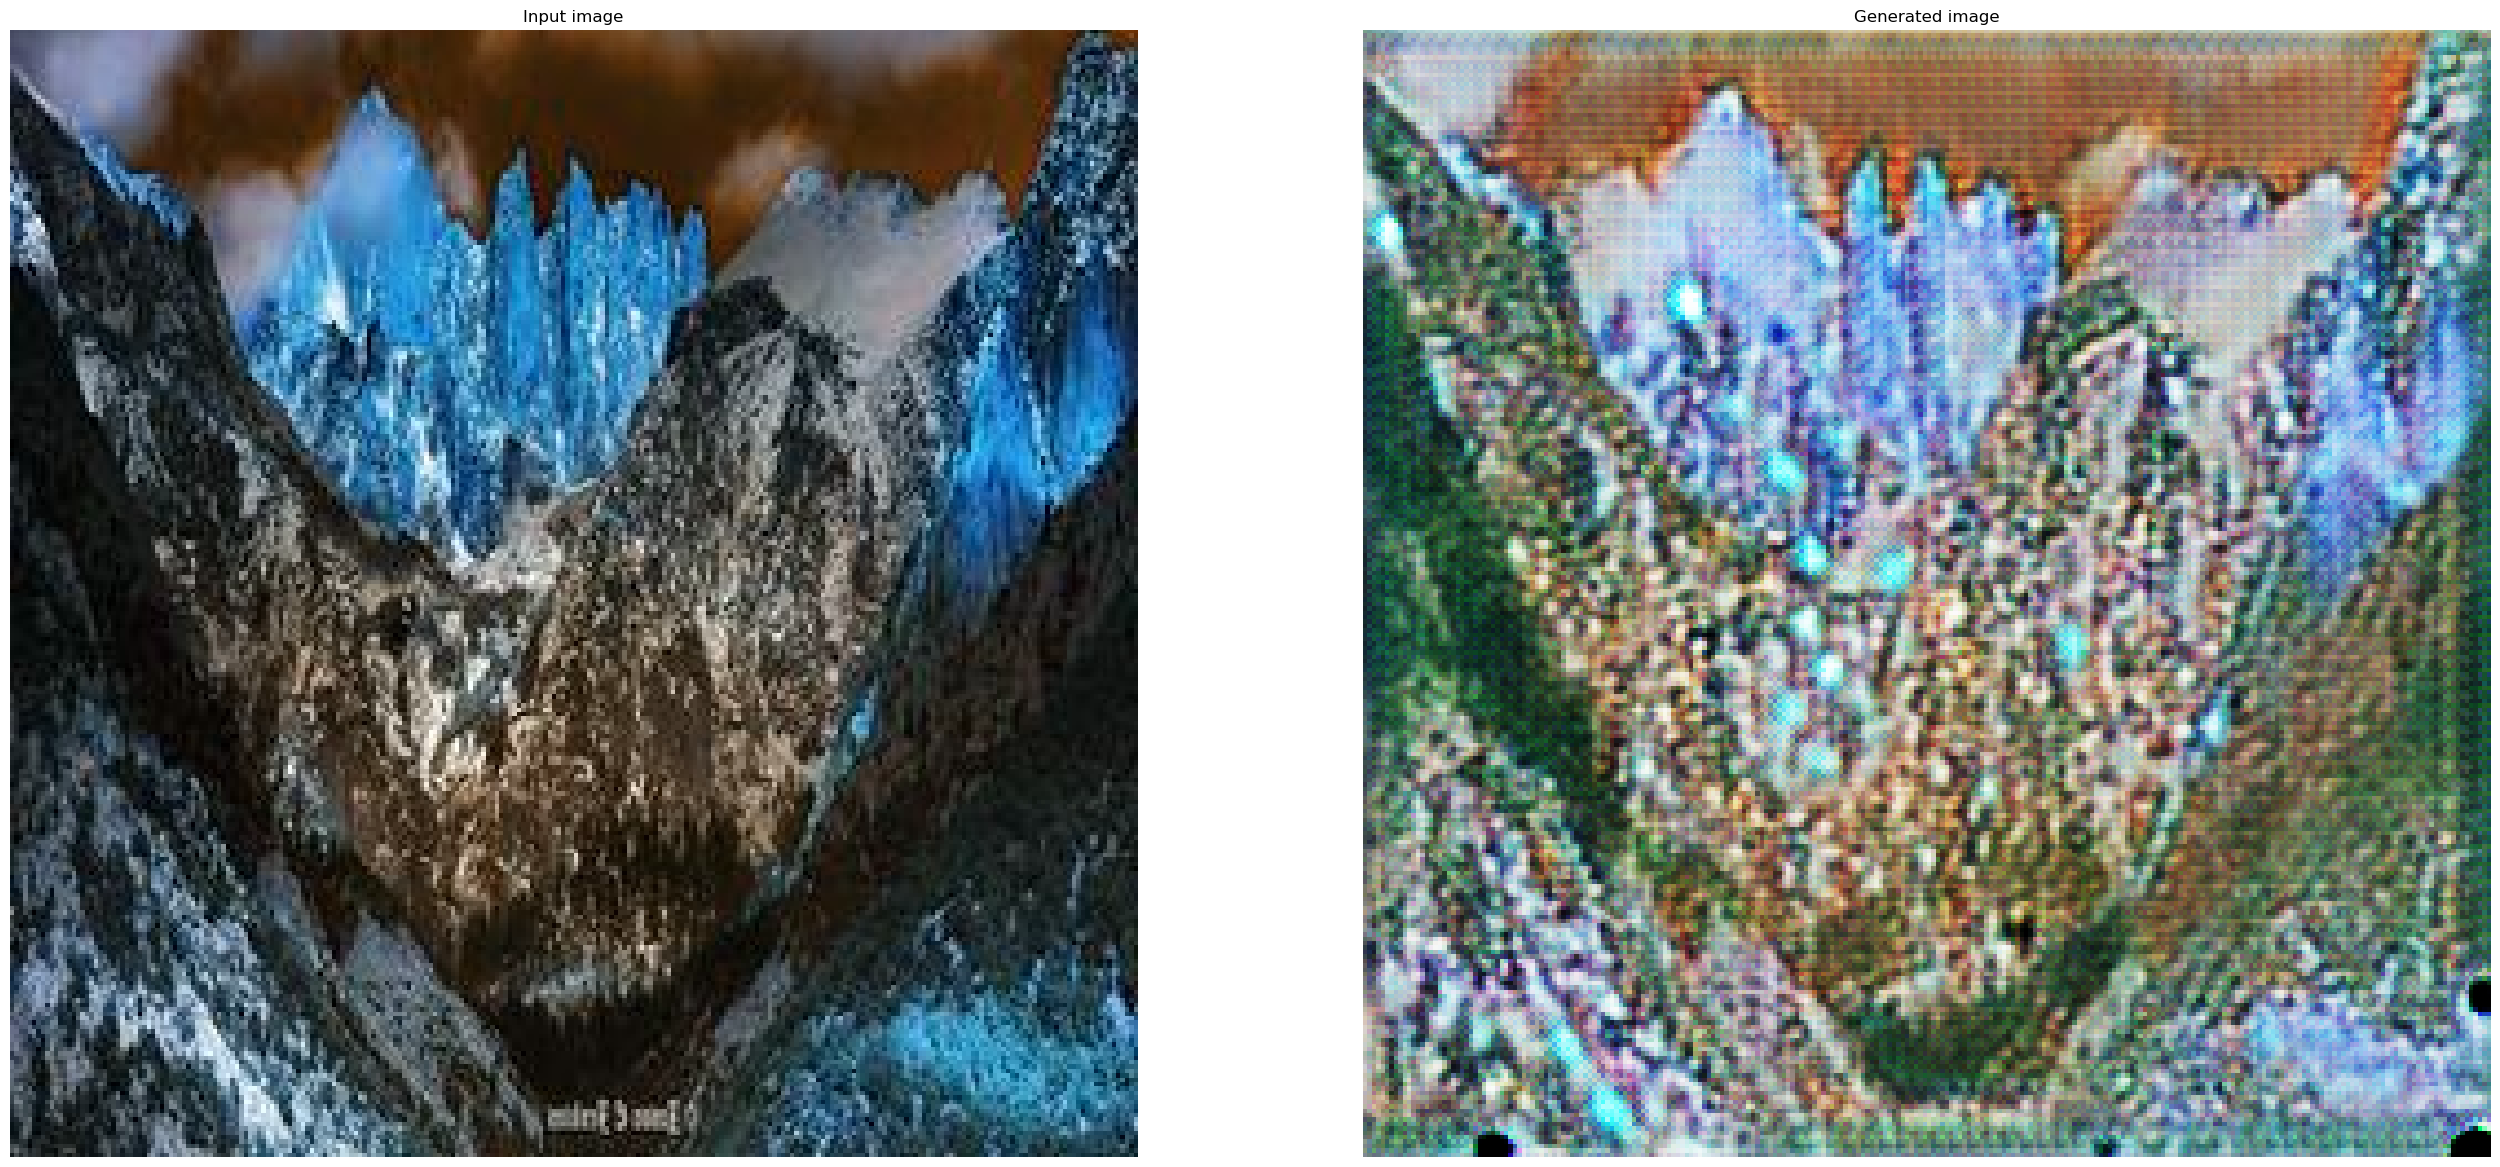

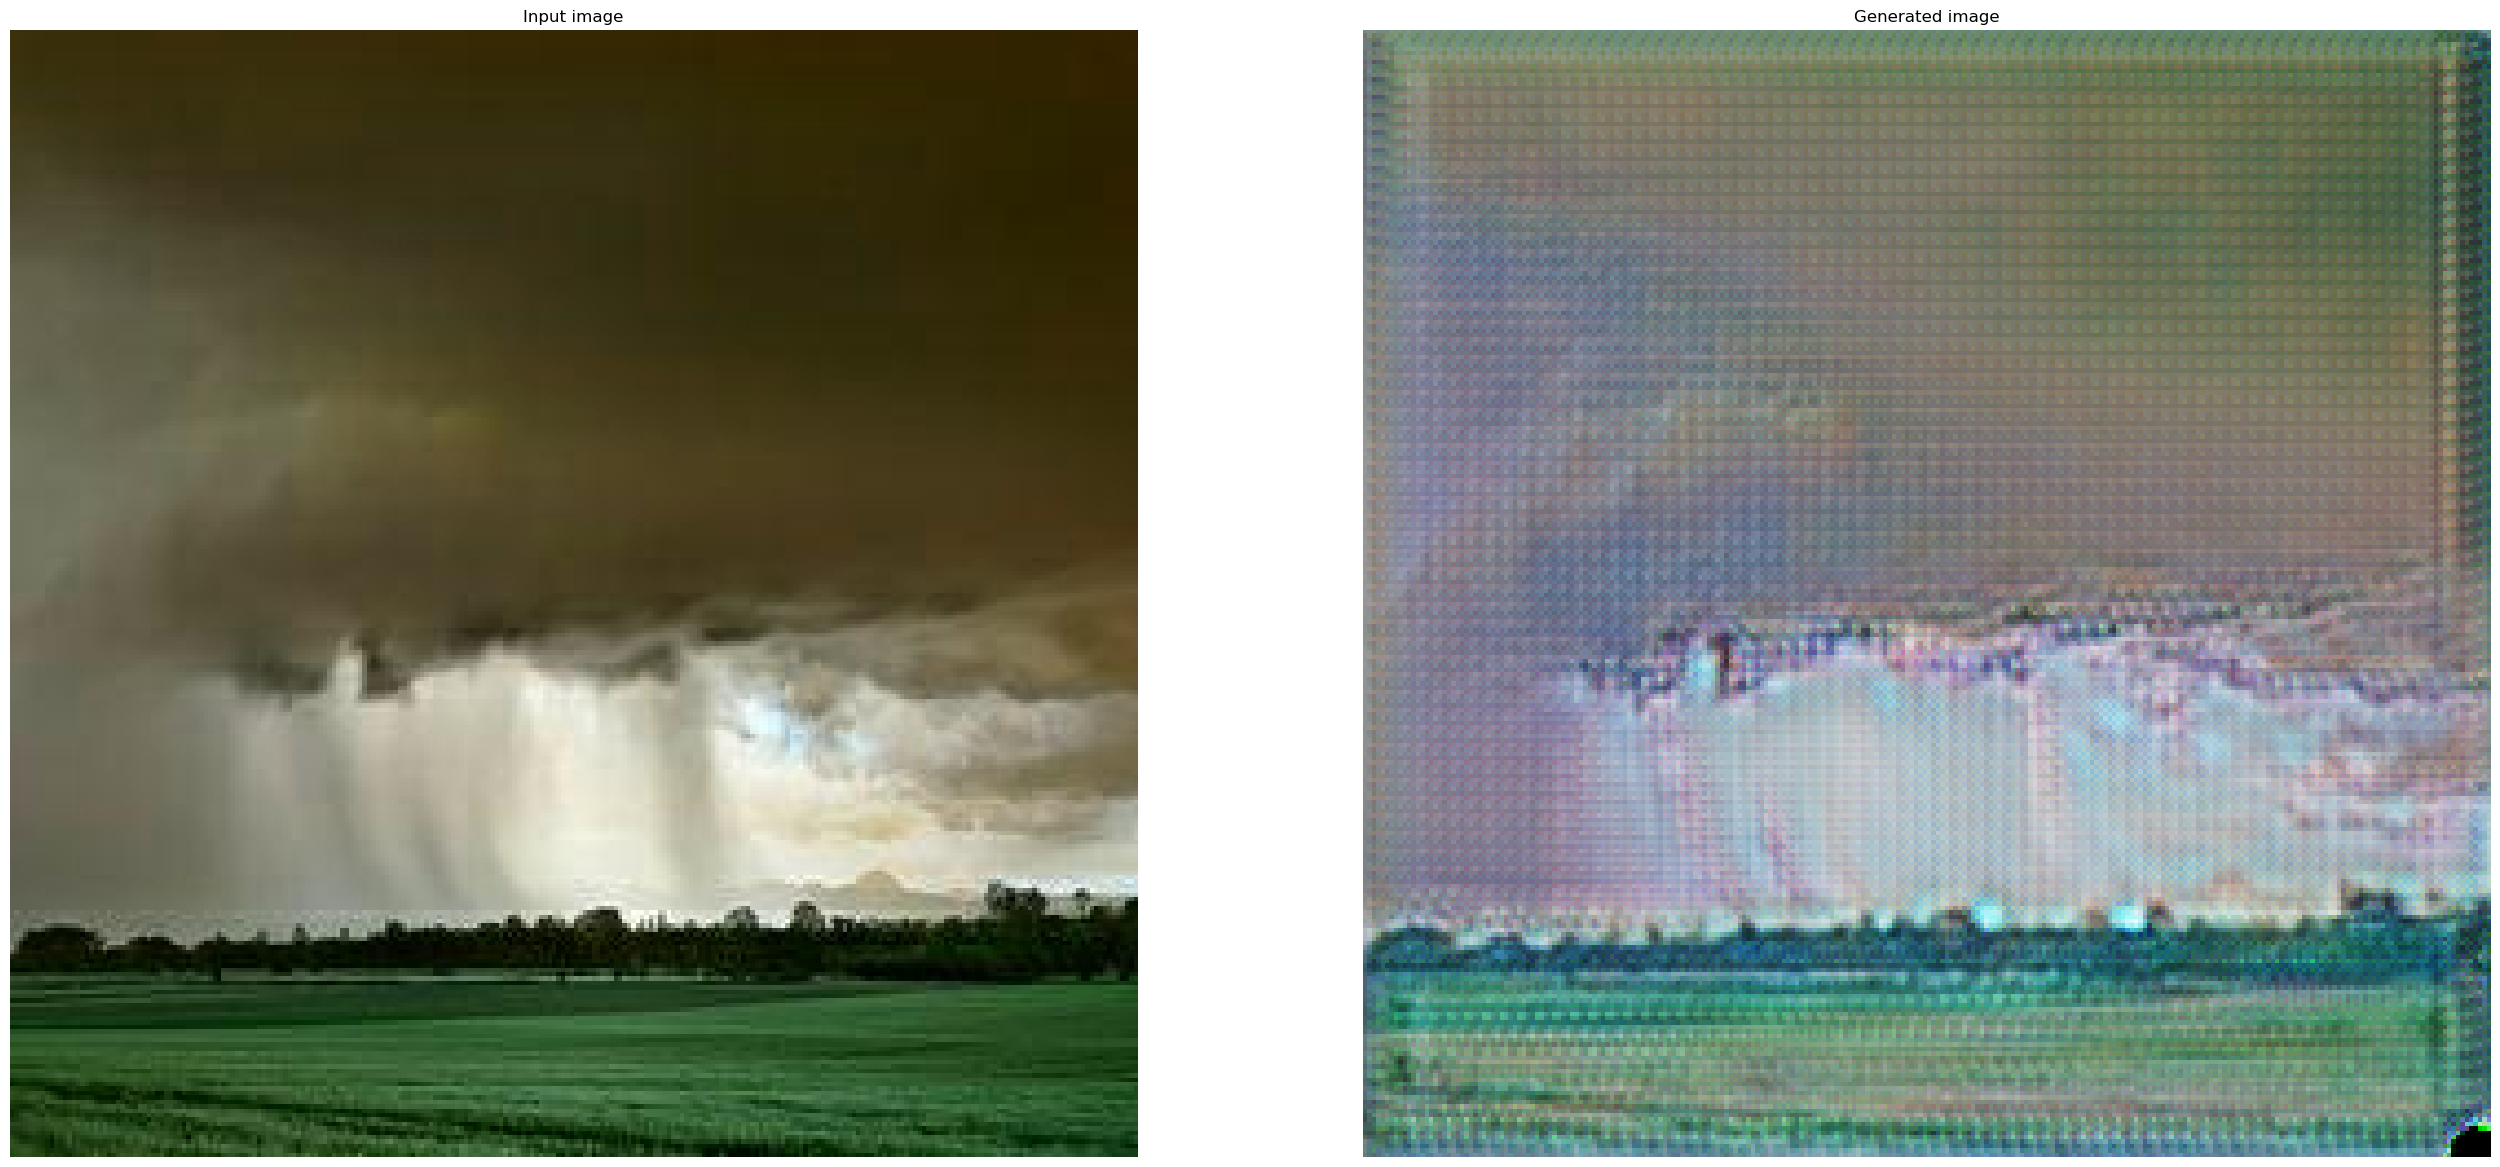

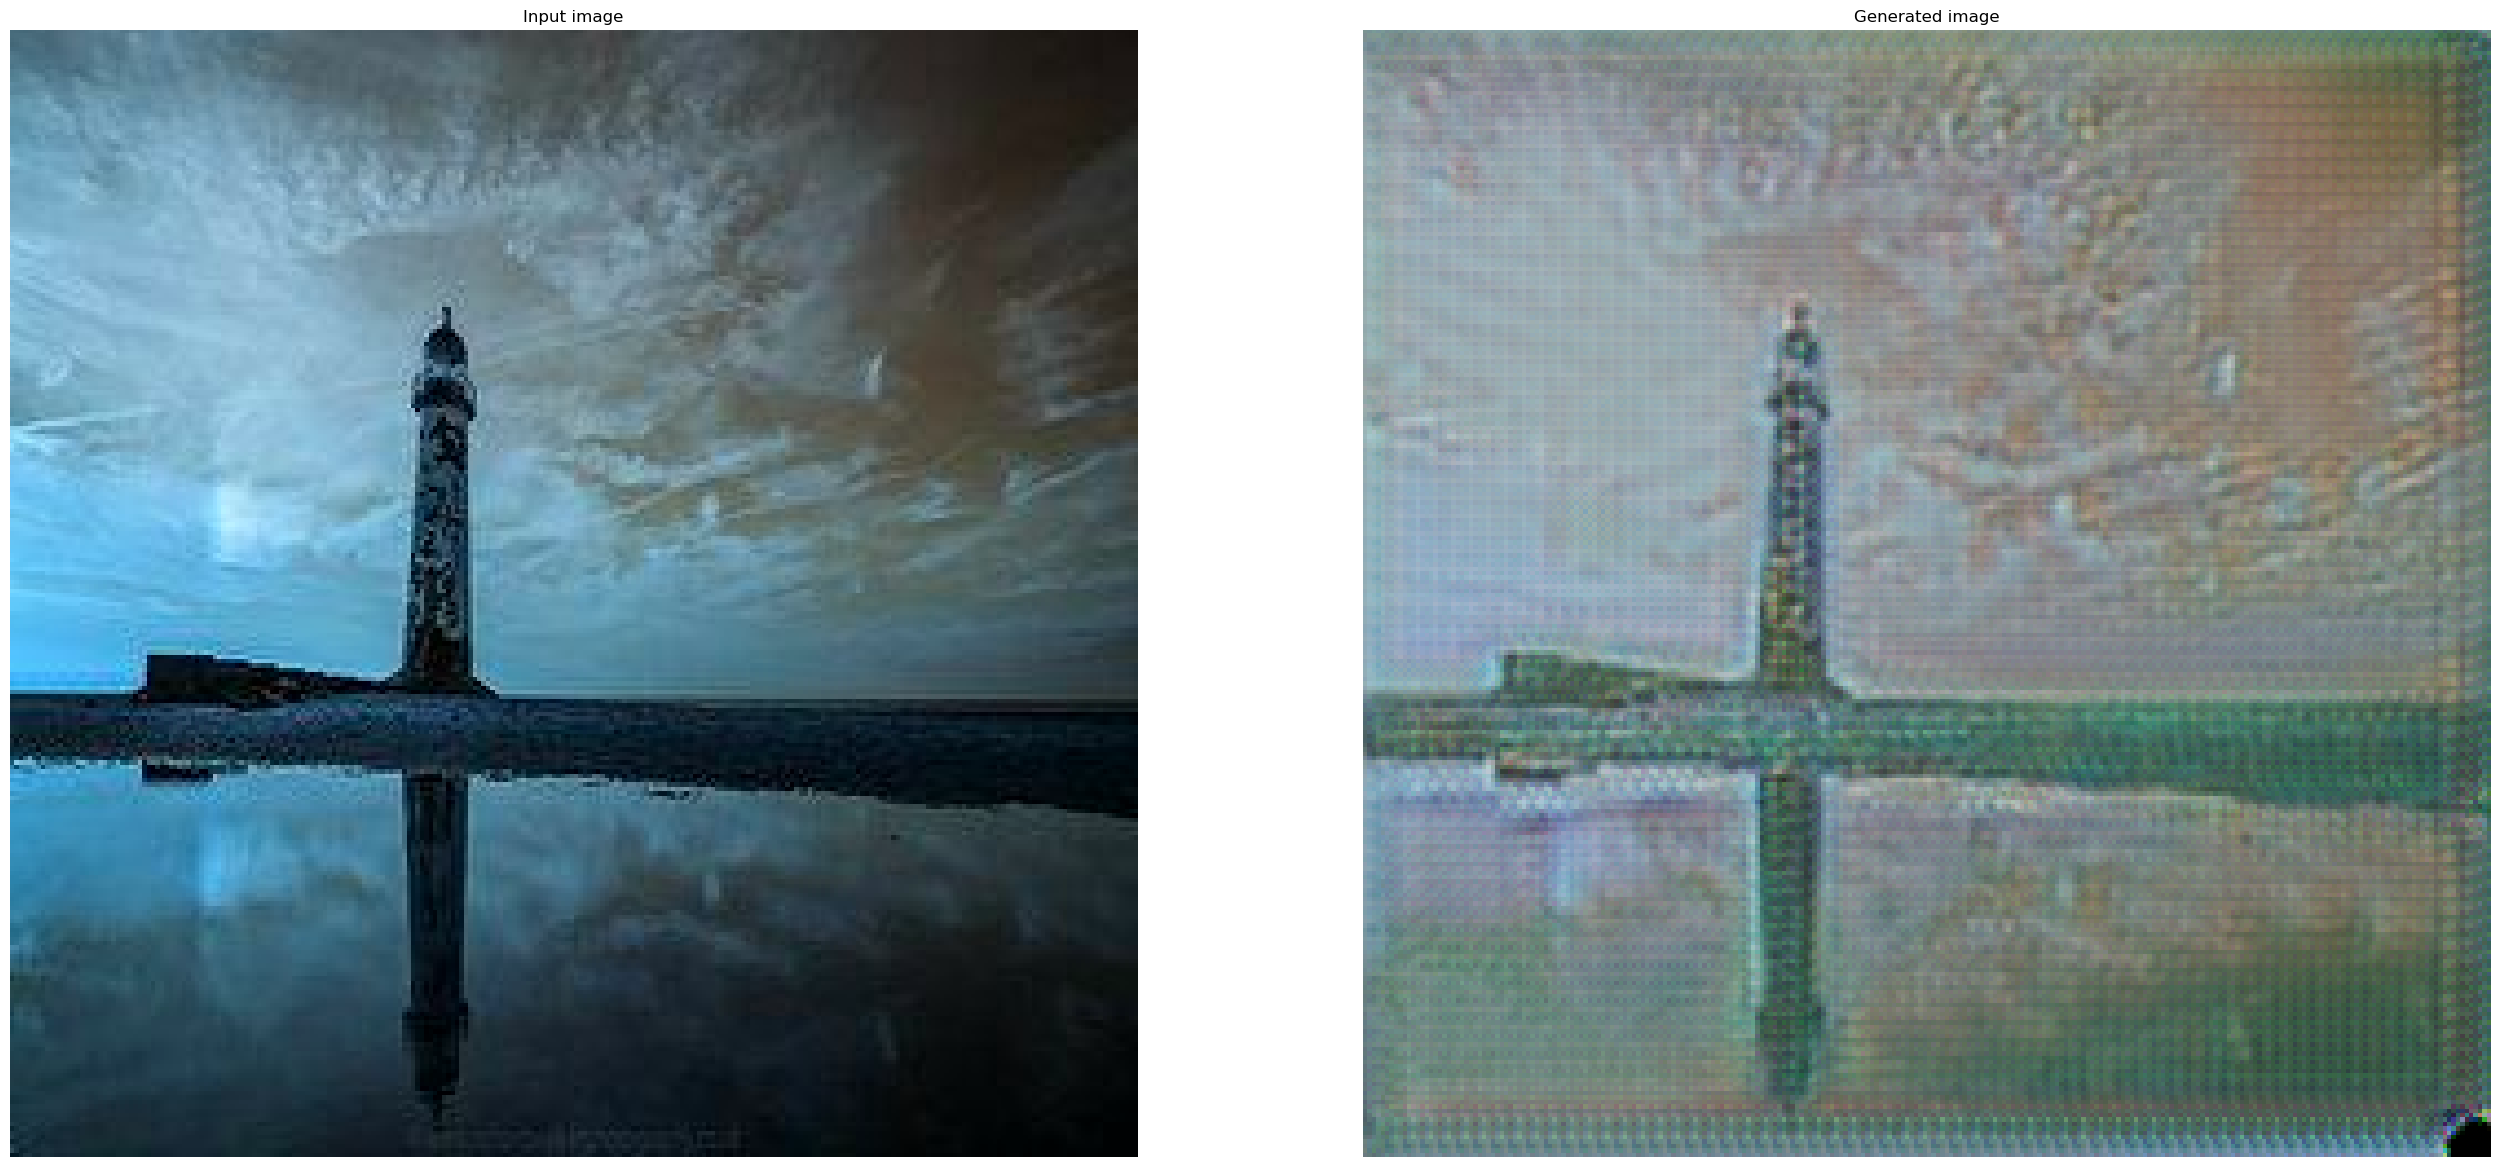

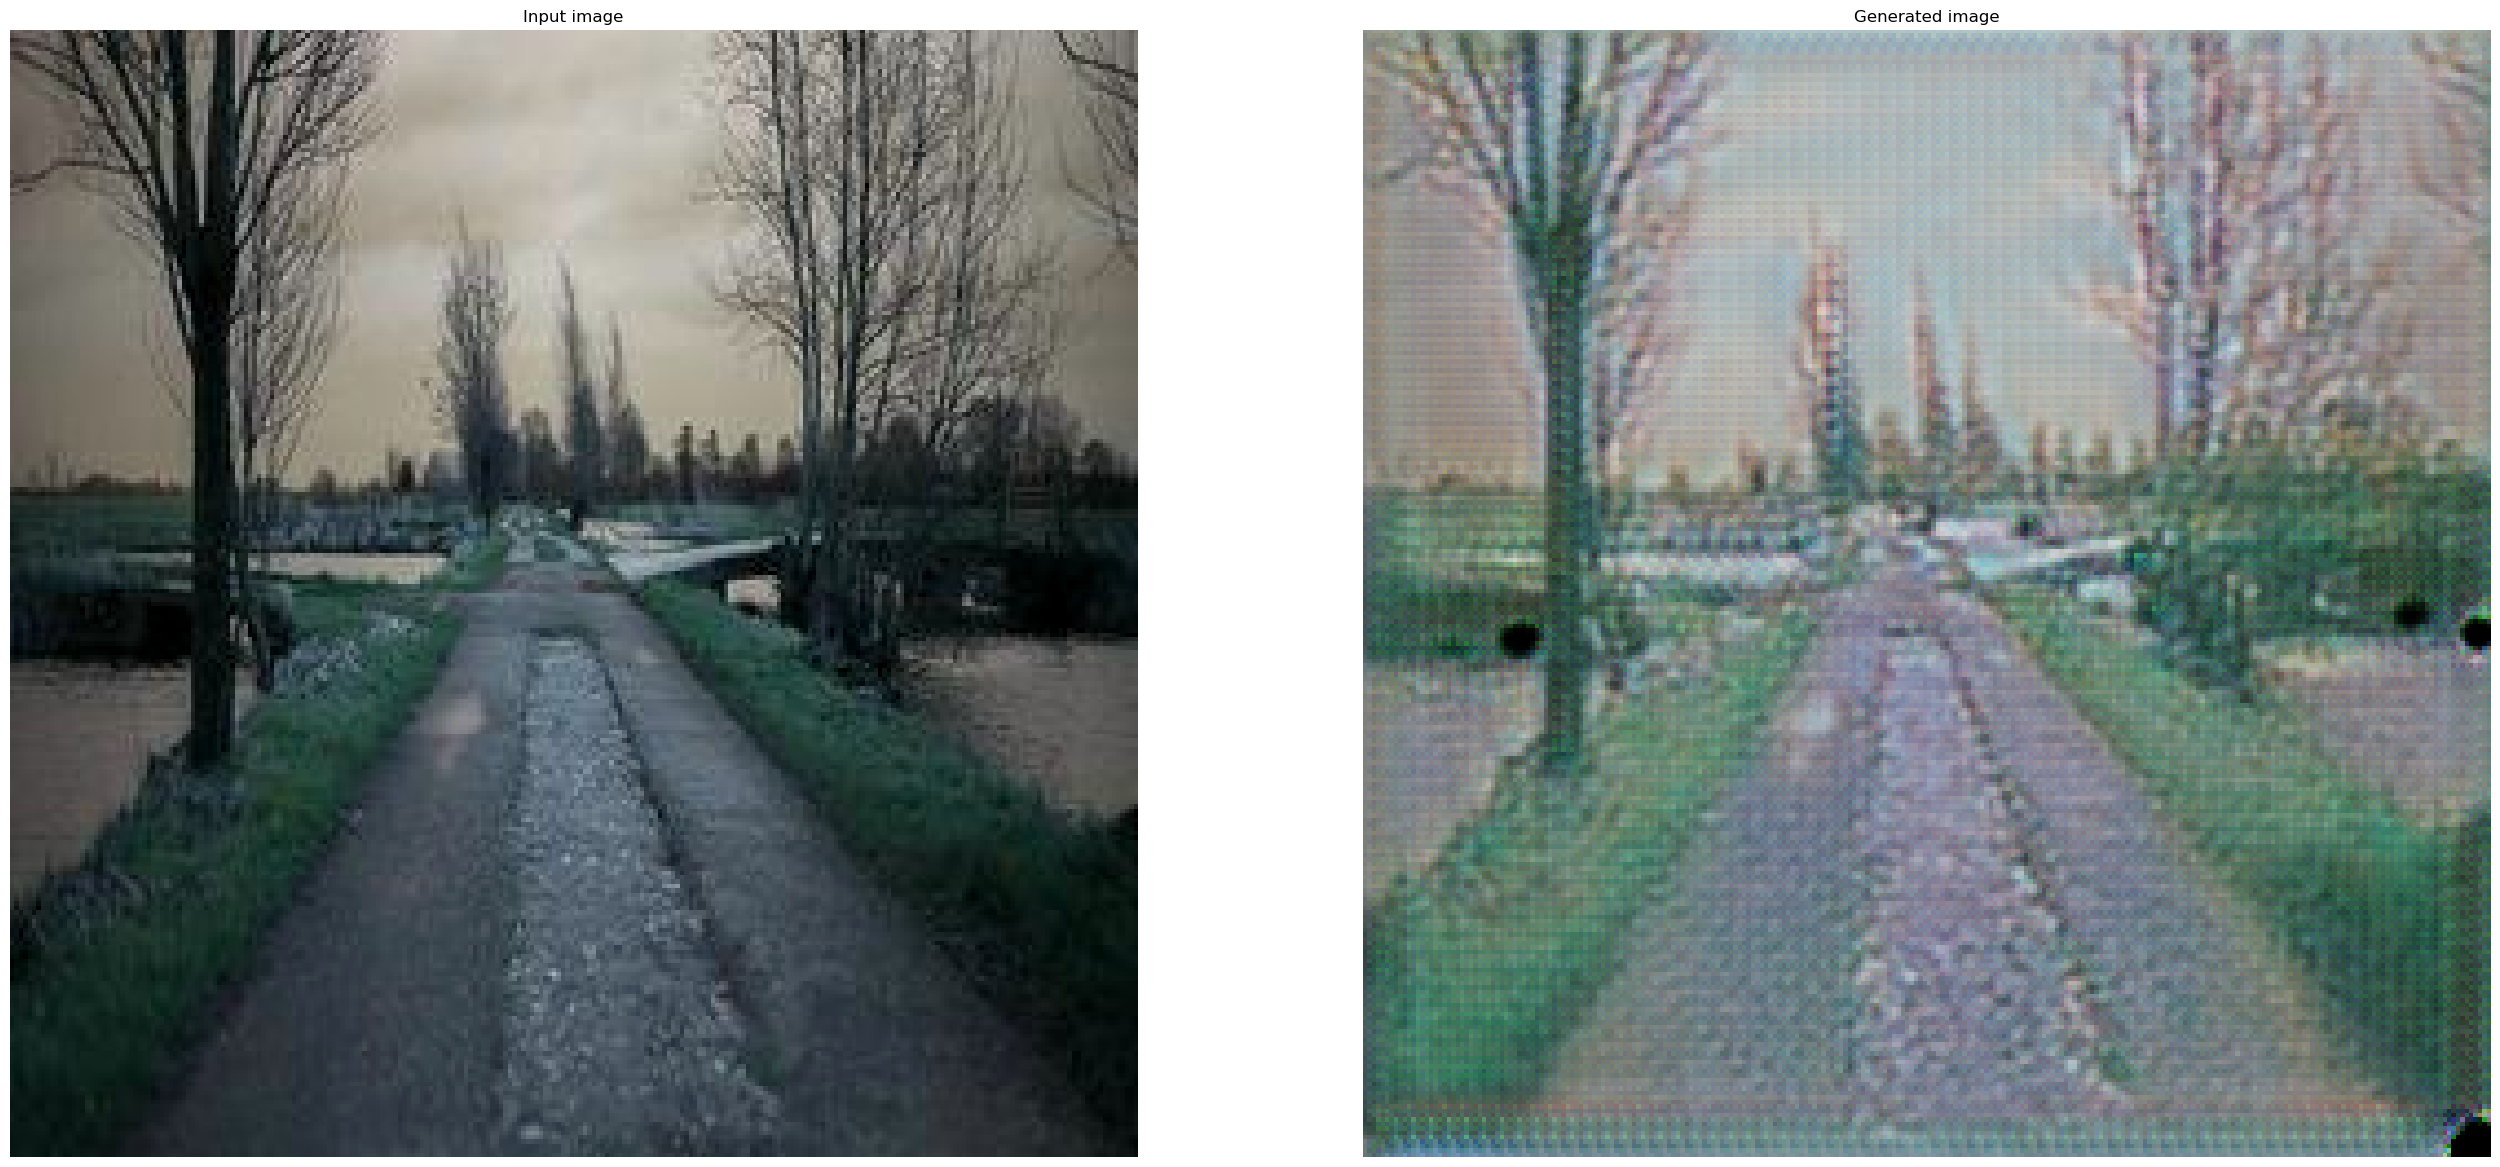

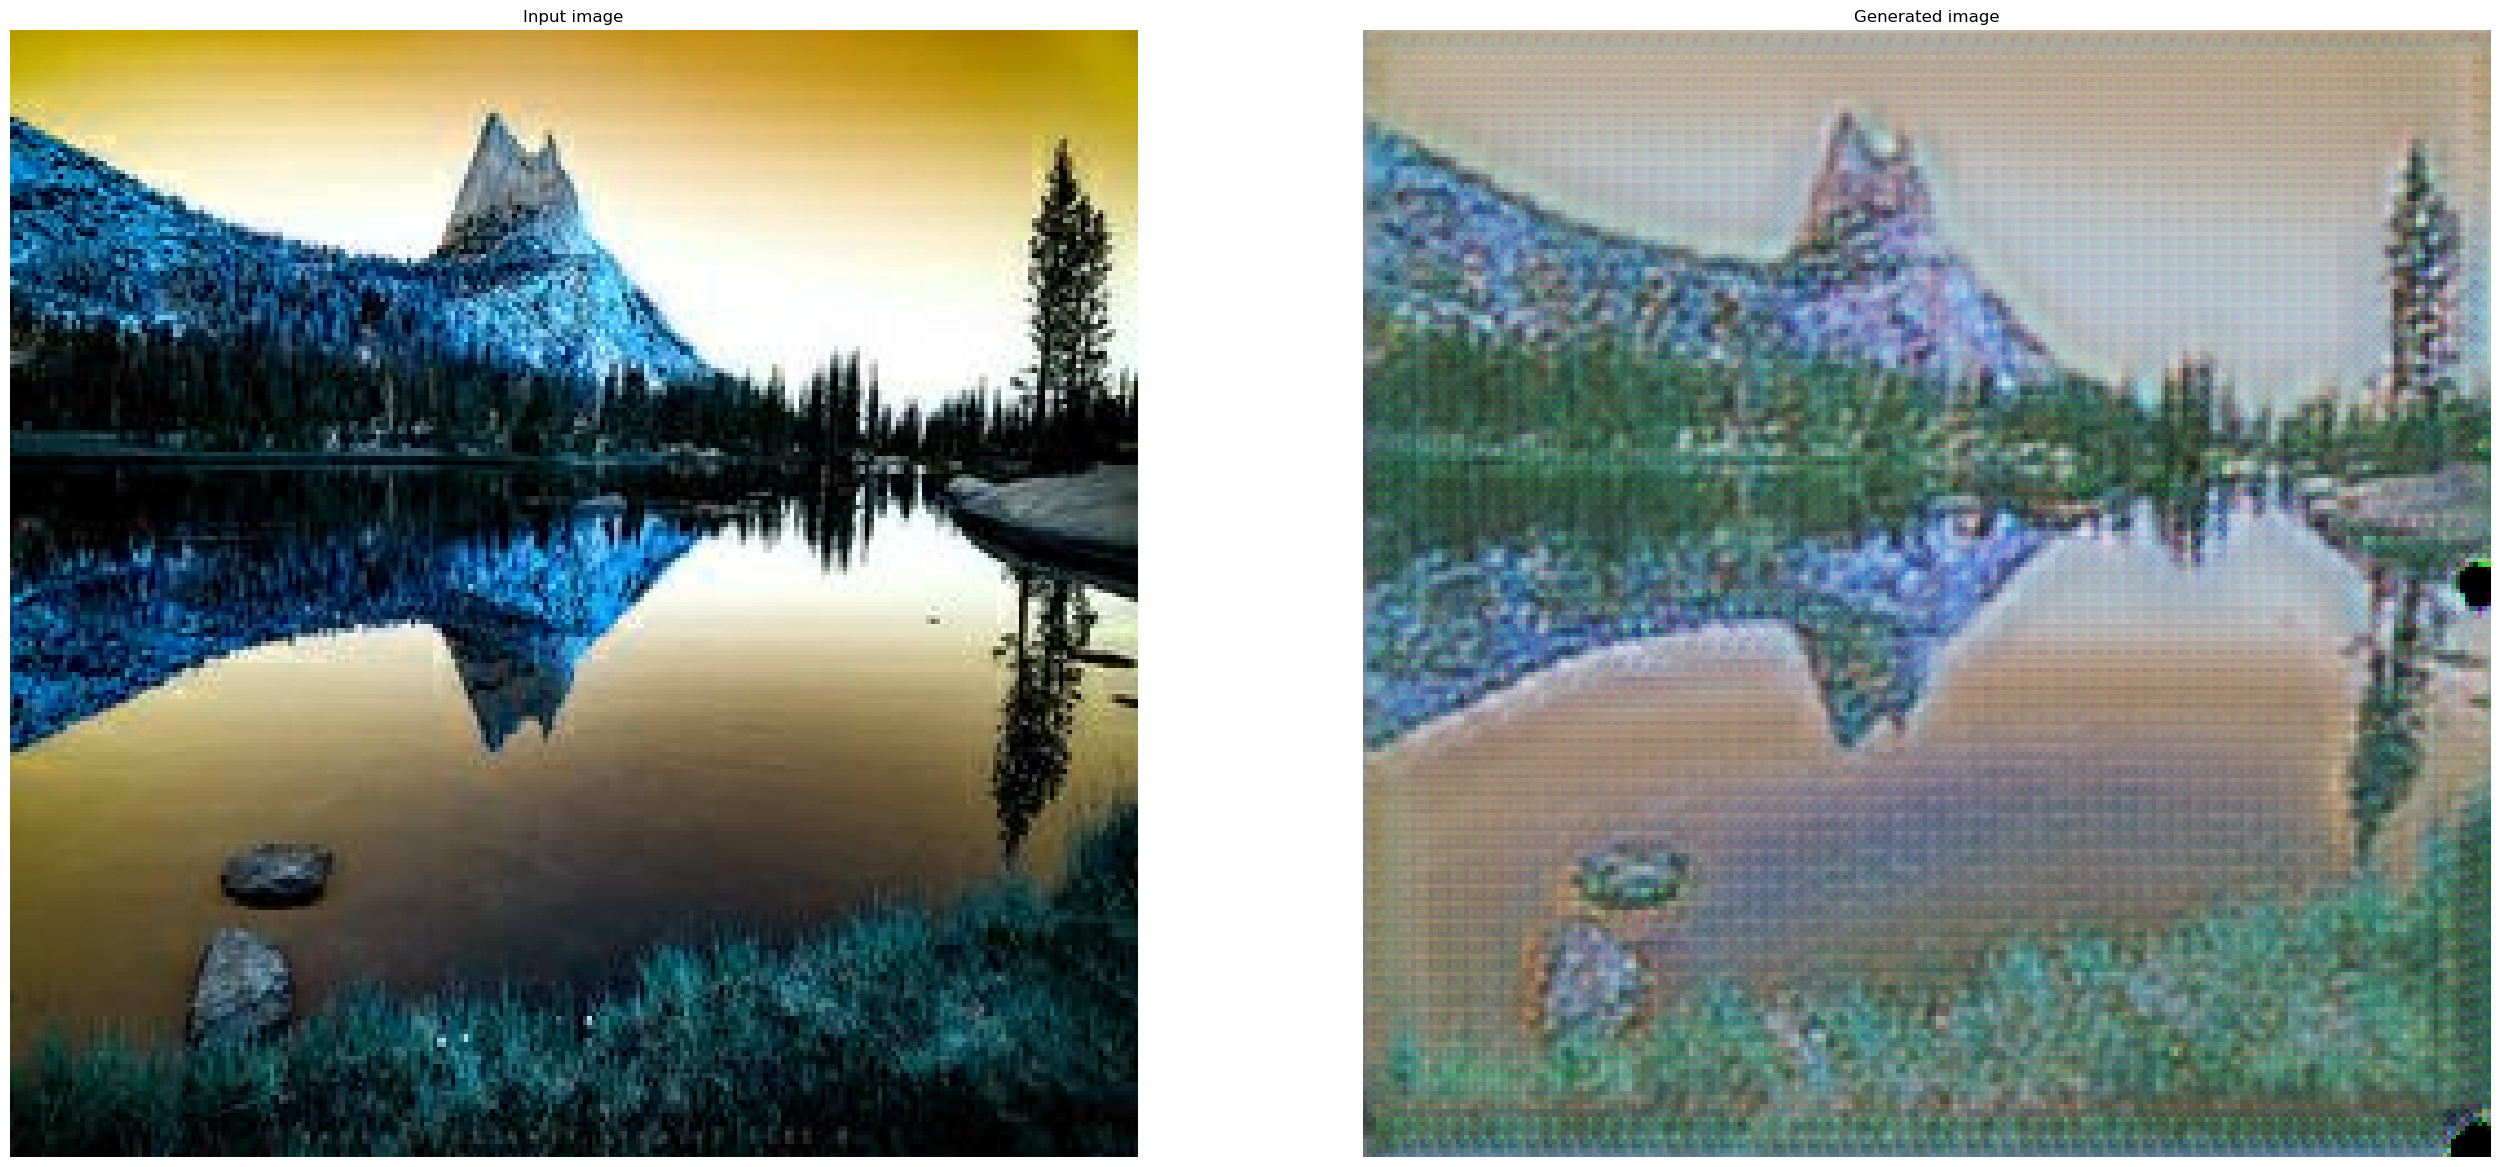

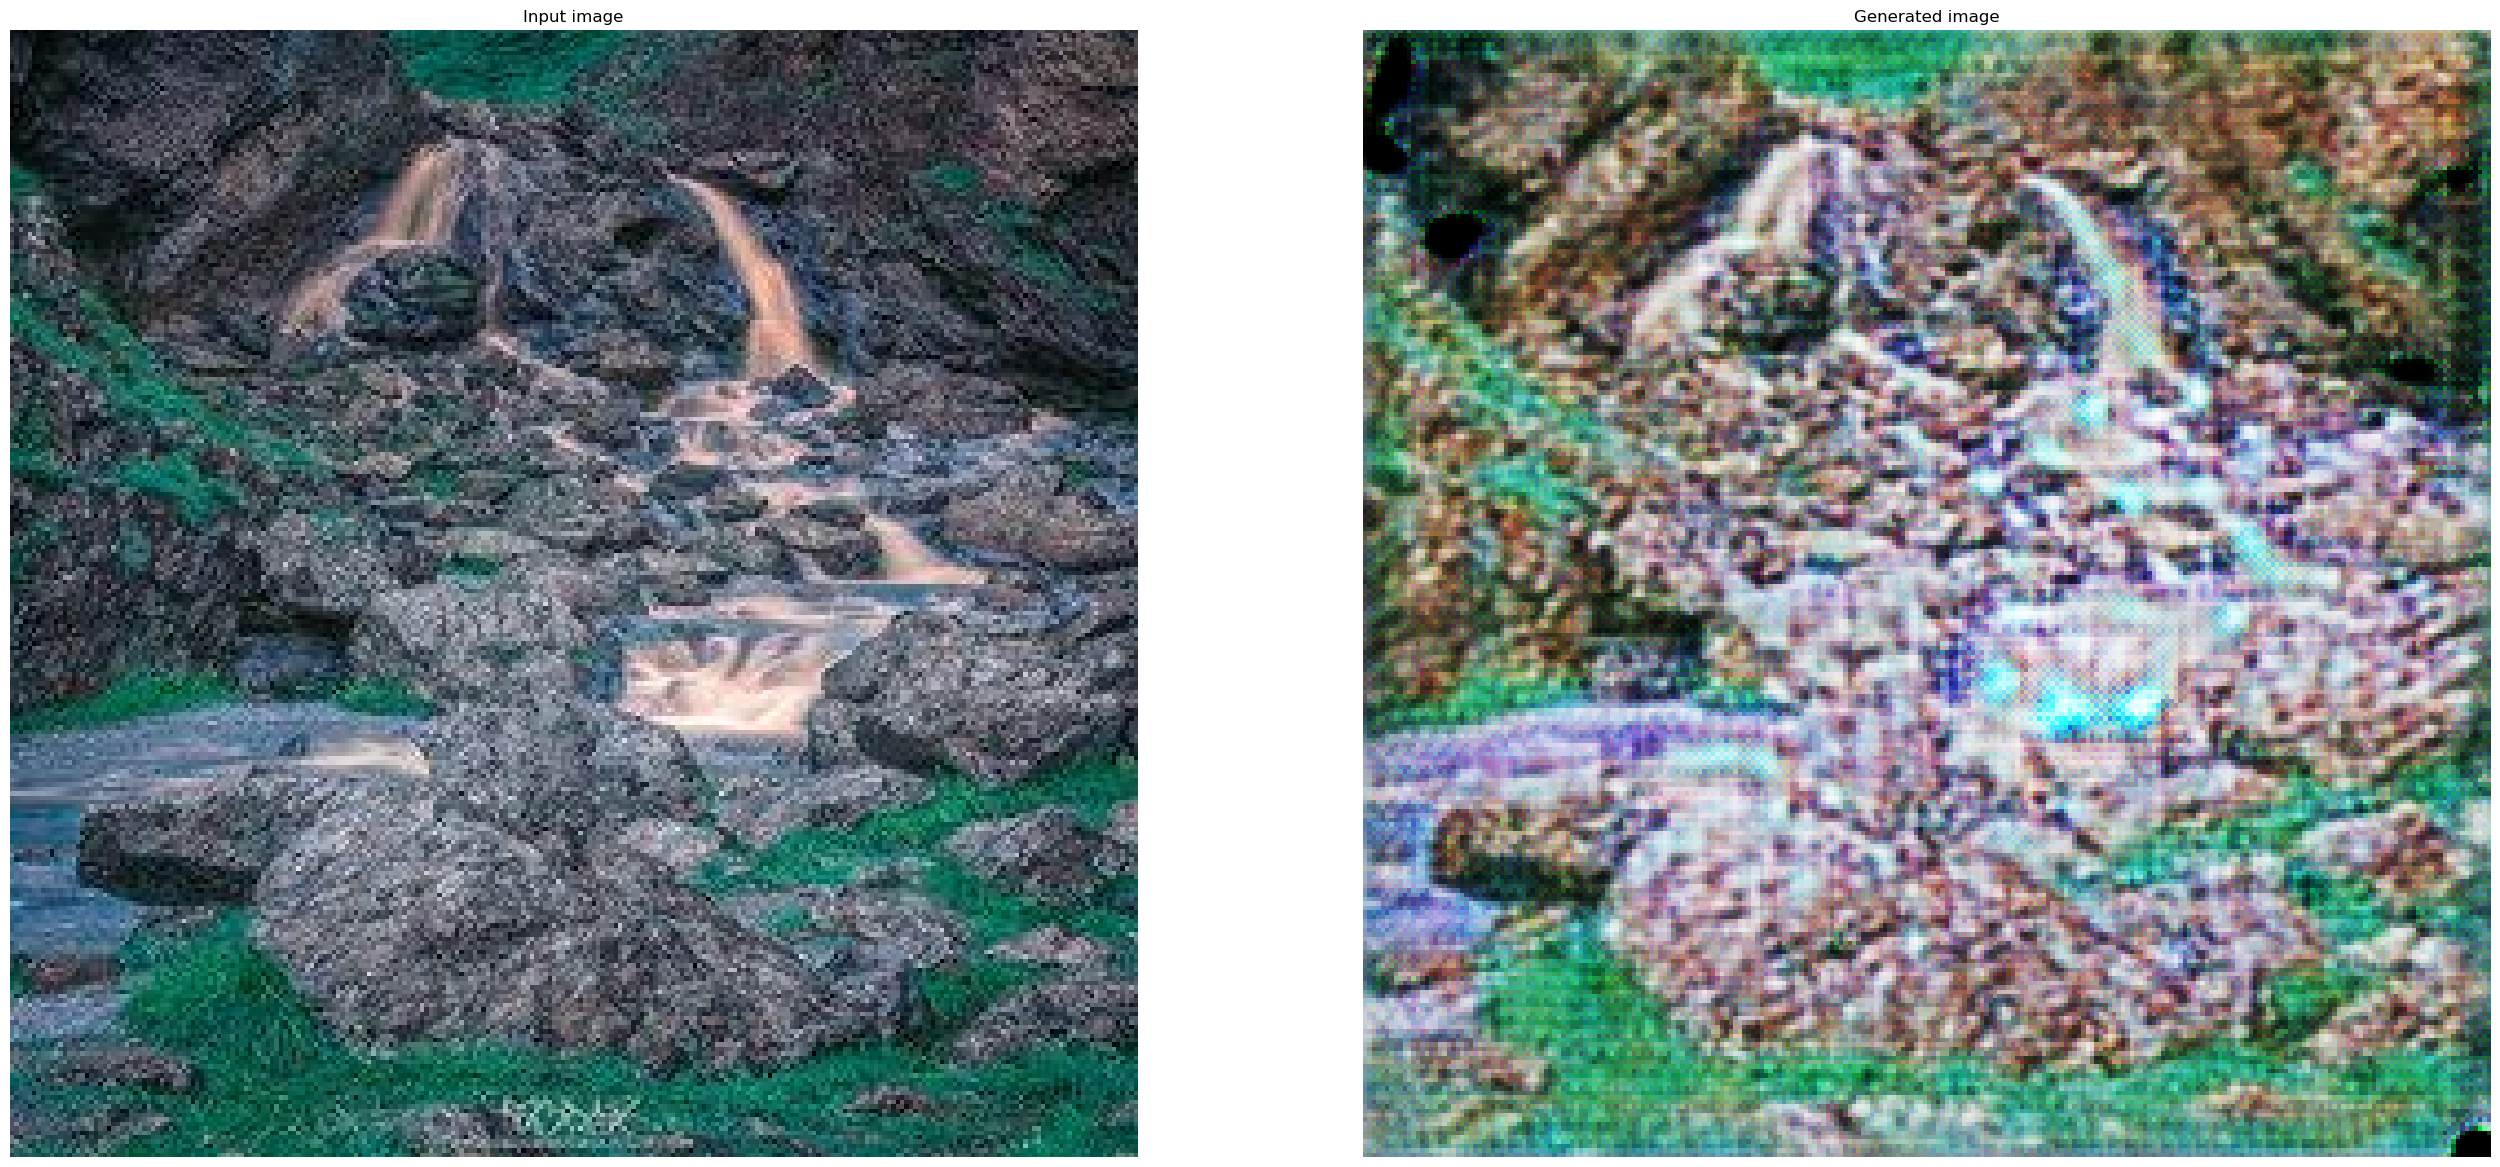

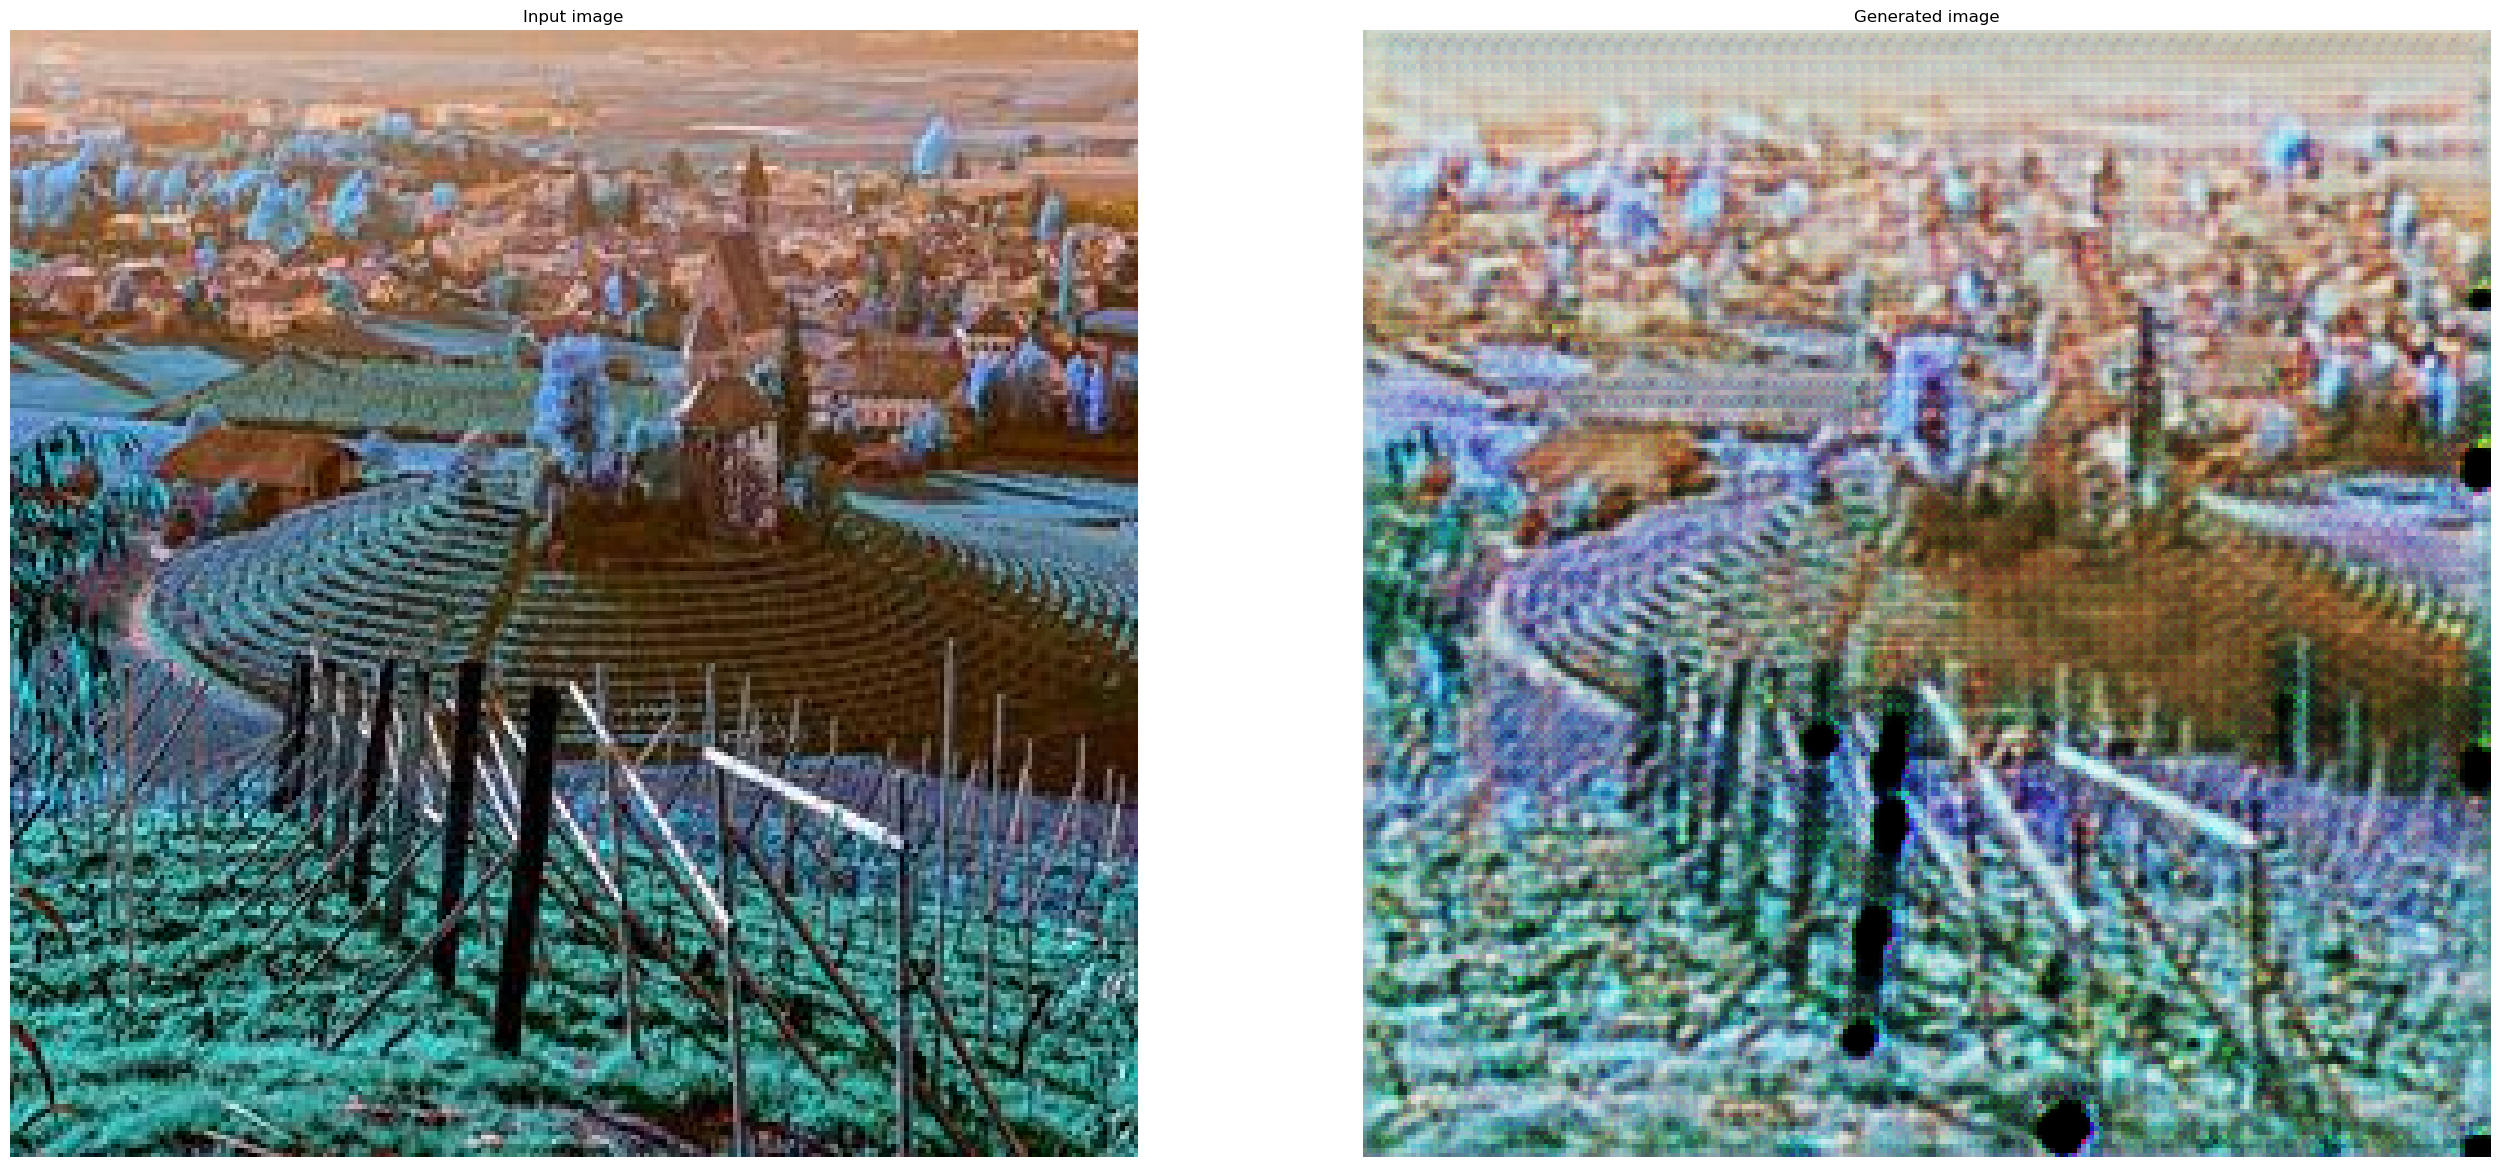

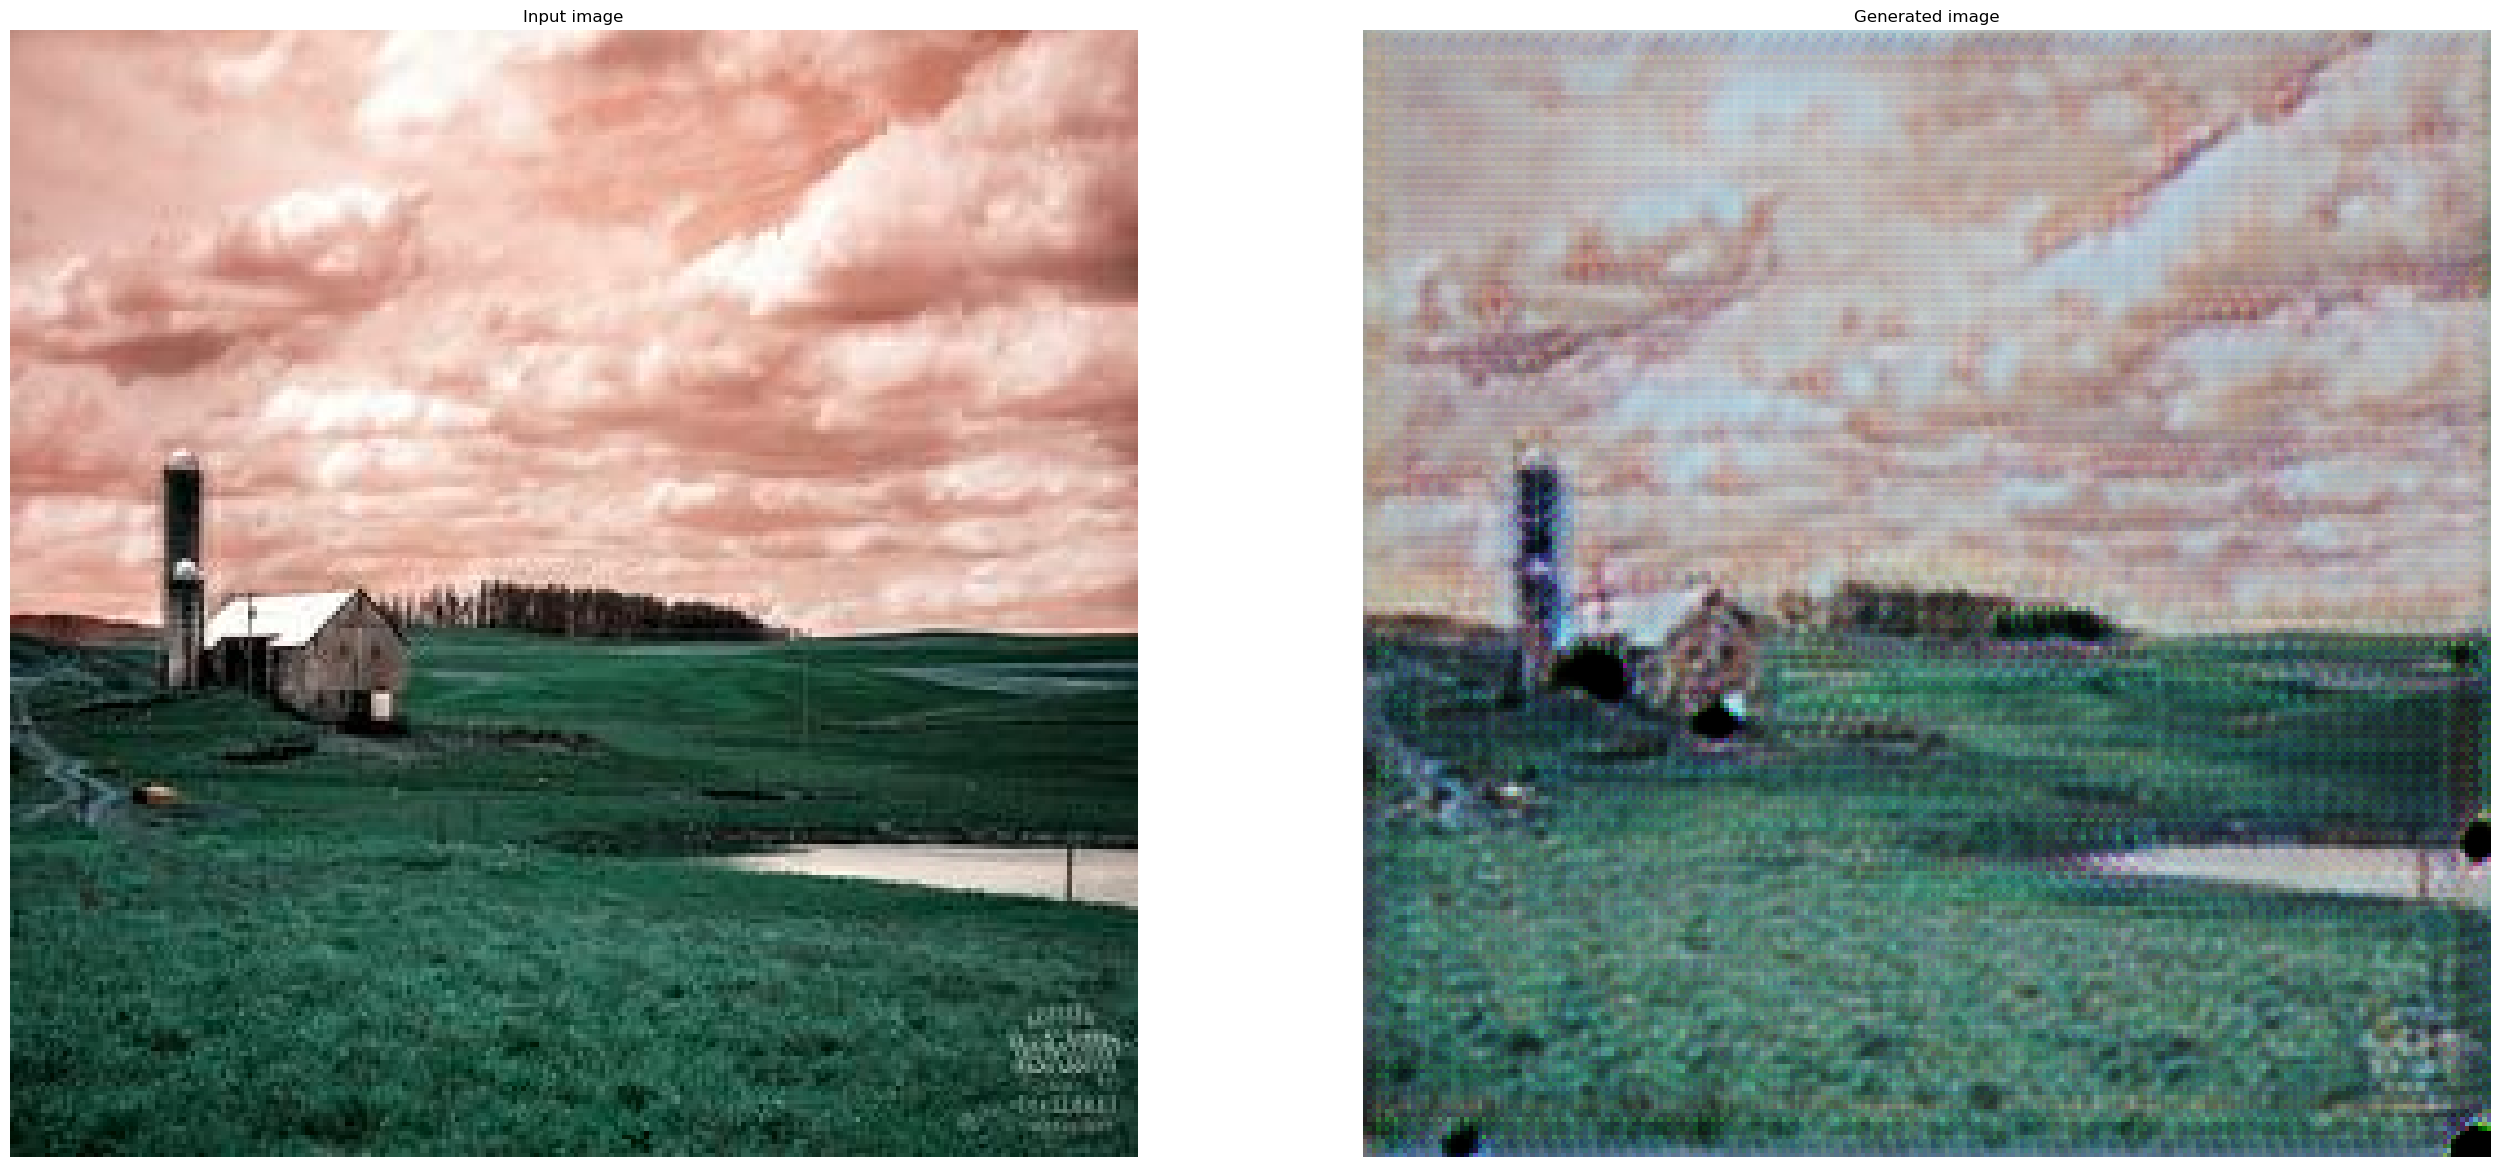

In [28]:
ds_iter = iter(photo1)
for n_sample in range(8):
    examples = next(ds_iter)
    generate = monet_generator(examples)
    
    f = plt.figure(figsize=(32, 32))
    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(examples[0] * 0.5 + 0.5)
    plt.axis('off')
        
    plt.subplot(122)
    plt.title('Generated image')
    plt.imshow(generate[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()

## **Conclusion**

Although the model and training worked, the generator seems not very well. At least based on what we plotted the result, it is still not very close to Monet-style. I was trying to change some parameters and re-train the model. However, when I tried to use TPU as my accelerator, there's a very long queue so I was not able to do this faster at this moment. The tutorial notebook helped me a lot on this project, it would be impossible without the very detailed explaination. 
As my first Generative adversarial networks model, it is a very great chance to learn how to create a GAN in tensorflow. Also, in data augmentation, I should probably do a little more on this, such as resizing, zooming or other rotations methods. 
To understand how generator and discriminator work, will be helpful when we are going to try some other parameters or build different layers to learn how to improve the model performance. This is just a start in deep learning, and I believe I still have a lot work need to be done to get ready for the next level.

## **Submission**

In [29]:
import PIL

! mkdir ../images

In [31]:
i = 1
for img in photo1:
    gene = monet_generator(img, training=False).numpy()
    gene = (gene * 127.5 + 127.5).astype(np.uint8)
    for g in gene:
        im = PIL.Image.fromarray(g)
        im.save("../images/" + str(i) + ".jpg")
        i += 1

In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'